In [1]:
import os
import json
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import tempfile
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import AutoImageProcessor, AutoConfig, AutoModelForObjectDetection

import json
import numpy as np
import albumentations as A 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random


/home/ovgu/PycharmProjects/assignment2/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ovgu/PycharmProjects/assignment2/.venv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Custom Dataset for AUAIR Object Detection
This class defines a custom PyTorch Dataset for loading and preprocessing the AUAIR object detection dataset, which follows a COCO-like annotation format. It also integrates Albumentations for data augmentation.

In [2]:
class AUAIRDataset(Dataset):
    def __init__(self, image_dir, annotation_path, processor, transforms=None):
        self.image_dir = image_dir
        self.processor = processor
        self.transforms = transforms
        with open(annotation_path, 'r') as f: data = json.load(f)
        self.entries = data["annotations"]
        self.class_names = data["categories"] 
        self.num_classes = len(self.class_names)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        image_path = os.path.join(self.image_dir, entry["image_name"])
        image = Image.open(image_path).convert("RGB")
        original_w, original_h = image.size

        # Prepare original annotations & filter invalid originals
        original_bboxes_coco = []
        original_class_labels = []
        if entry.get("bbox"):
            for obj in entry["bbox"]:
                width = obj.get("width", 0.0)
                height = obj.get("height", 0.0)
                class_id = obj.get("class")
                if width > 0 and height > 0 and class_id is not None:
                    # Assume types are correct, minimal conversion
                    original_bboxes_coco.append([float(obj["left"]), float(obj["top"]), float(width), float(height)])
                    original_class_labels.append(int(class_id))

        # Apply Albumentations transforms if they exist
        img_np = np.array(image)
        bboxes = original_bboxes_coco
        labels = original_class_labels
        if self.transforms:
            transformed = self.transforms(image=img_np, bboxes=bboxes, class_labels=labels)
            img_np = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['class_labels']
            # Minimal filter after transform
            valid_indices = [i for i, bbox in enumerate(bboxes) if bbox[2] > 0 and bbox[3] > 0]
            bboxes = [bboxes[i] for i in valid_indices]
            labels = [labels[i] for i in valid_indices]

        # Prepare annotations for HF processor
        hf_annotations = [{"image_id": idx, "category_id": label, "bbox": bbox, "area": bbox[2] * bbox[3], "iscrowd": 0}
                          for bbox, label in zip(bboxes, labels)]
        target = {'image_id': idx, 'annotations': hf_annotations}

        # Process with HF processor
        image_to_process = Image.fromarray(img_np)
        encoding = self.processor(images=image_to_process, annotations=target, return_tensors="pt")

        # Finalize output structure 
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        if "pixel_mask" in encoding: encoding["pixel_mask"] = encoding["pixel_mask"].squeeze(0)
        processed_labels = encoding.pop('labels', None)
        encoding['orig_size'] = torch.tensor([original_h, original_w], dtype=torch.long)
        encoding['labels'] = processed_labels 

        return encoding

## Class Mappings for AUAIR Dataset

In [3]:
categories = ["Human", "Car", "Truck", "Van", "Motorbike", "Bicycle", "Bus", "Trailer"]

id2label = {i: name for i, name in enumerate(categories)}
label2id = {name: i for i, name in enumerate(categories)}

In [4]:
id2label

{0: 'Human',
 1: 'Car',
 2: 'Truck',
 3: 'Van',
 4: 'Motorbike',
 5: 'Bicycle',
 6: 'Bus',
 7: 'Trailer'}

## Custom Collate Function for Dataloader
It defines a custom_collate_fn used in the DataLoader to batch together multiple samples from the dataset.

In [5]:
def custom_collate_fn(batch):
    # batch is a list of dictionaries from your Dataset's __getitem__

    pixel_values = [item["pixel_values"] for item in batch] # Assuming shape is (3, H, W)
    pixel_values = torch.stack(pixel_values) # Stack -> (B, 3, H, W)

    labels = [item["labels"][0] for item in batch]

    orig_sizes = [item['orig_size'] for item in batch] # Get the tensor [h, w] for each item

    return {
        "pixel_values": pixel_values,
        "labels": labels, 
        "orig_size": orig_sizes
    }

## Data Augmentation with Albumentations
Designed to increase model robustness and generalization by applying different augmentation techniques such as flipping, rotating, blurring etc. Bounding box behavior is controlled using: format='coco': 
BBox format is [x_min, y_min, width, height].
With min_visibility=0.2 & min_area=25: bboxes that are too small or mostly invisible are filtered out. 

In [6]:
import albumentations as A

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5), 
    A.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.15, 
        rotate_limit=45, 
        p=0.7, 
        border_mode=0, 
        value=0 
    ),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),

    A.OneOf([ 
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=(3, 7), p=0.5),
    ], p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),

], bbox_params=A.BboxParams(
      format='coco',
      label_fields=['class_labels'],
      min_visibility=0.2, 
      min_area=25 
   )
)

val_test_transforms = A.Compose([], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels'])) 


/home/ovgu/PycharmProjects/assignment2/.venv/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


## Initialize Dataset and Processor
Handles image resizing and normalization compatible with the DETR model. Resizes images to 800×800 pixels.
Applies pixel normalization.

In [7]:
image_dir = "dataset/auair/images"
annotation_path = "dataset/auair/annotations.json"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained("facebook/detr-resnet-50")

In [10]:
processor = AutoImageProcessor.from_pretrained(
    "facebook/detr-resnet-50",
    do_resize=True,
    do_normalize=True,
    size = {"height": 800, "width": 800}
)

In [11]:
dataset = AUAIRDataset(image_dir, annotation_path, processor)

In [12]:
train_full_dataset = AUAIRDataset(image_dir, annotation_path, processor, transforms=train_transforms)
val_test_full_dataset = AUAIRDataset(image_dir, annotation_path, processor, transforms=val_test_transforms)

## Stratified Dataset Splitting and DataLoader Initialization
This cell handles dataset splitting with multilabel stratification to ensure that all object classes are represented proportionally across splits. It also creates PyTorch DataLoaders for training, validation, and test sets.

In [13]:
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_STATE_1 = 42
RANDOM_STATE_2 = 43
BATCH_SIZE = 8 
NUM_WORKERS = 4 
PIN_MEMORY = torch.cuda.is_available()

def _get_img_class_vec(entry, num_classes):
    vec = [0] * num_classes
    if entry.get("bbox"):
        for obj in entry.get("bbox", []):
            class_idx = obj.get("class")
            if class_idx is not None:
                try:
                    class_idx = int(class_idx)
                    if 0 <= class_idx < num_classes: vec[class_idx] = 1
                except (ValueError, TypeError): pass
    return vec

num_classes = val_test_full_dataset.num_classes 
image_class_vectors = np.array([_get_img_class_vec(e, num_classes) for e in val_test_full_dataset.entries]) # Get vectors from entries

if image_class_vectors.size == 0: raise ValueError("Class vectors empty.")

temp_split_size = VAL_SIZE + TEST_SIZE
splitter1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=temp_split_size, random_state=RANDOM_STATE_1)
train_idx, temp_idx = next(splitter1.split(np.zeros((len(image_class_vectors), 1)), image_class_vectors))

relative_test_size = TEST_SIZE / temp_split_size
splitter2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=relative_test_size, random_state=RANDOM_STATE_2)
val_rel_idx, test_rel_idx = next(splitter2.split(np.zeros((len(temp_idx), 1)), image_class_vectors[temp_idx]))

temp_idx_arr = np.array(temp_idx)
val_idx = temp_idx_arr[val_rel_idx]
test_idx = temp_idx_arr[test_rel_idx]

train_dataset = Subset(train_full_dataset, train_idx)   
val_dataset = Subset(val_test_full_dataset, val_idx)      
test_dataset = Subset(val_test_full_dataset, test_idx)     

print(f"Dataset Split -> Train:{len(train_idx)} Val:{len(val_idx)} Test:{len(test_idx)}")
print(f"Proportions -> Train: {np.mean(image_class_vectors[train_idx], axis=0).round(3)}")
print(f"Val: {np.mean(image_class_vectors[val_idx], axis=0).round(3)}")
print(f"Test: {np.mean(image_class_vectors[test_idx], axis=0).round(3)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

Dataset Split -> Train:22964 Val:4930 Test:4929
Proportions -> Train: [0.144 0.896 0.245 0.238 0.009 0.028 0.021 0.062]
Val: [0.143 0.894 0.245 0.237 0.01  0.028 0.021 0.062]
Test: [0.143 0.894 0.245 0.237 0.01  0.028 0.021 0.062]


##  Load and Configure Pretrained DETR Model
This cell loads the pretrained DETR (DEtection TRansformer) model from Facebook and adapts it to the AUAIR dataset.

In [14]:
model = AutoModelForObjectDetection.from_pretrained(
   "facebook/detr-resnet-50",
    num_labels=8,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Visualize Images with Bounding Boxes

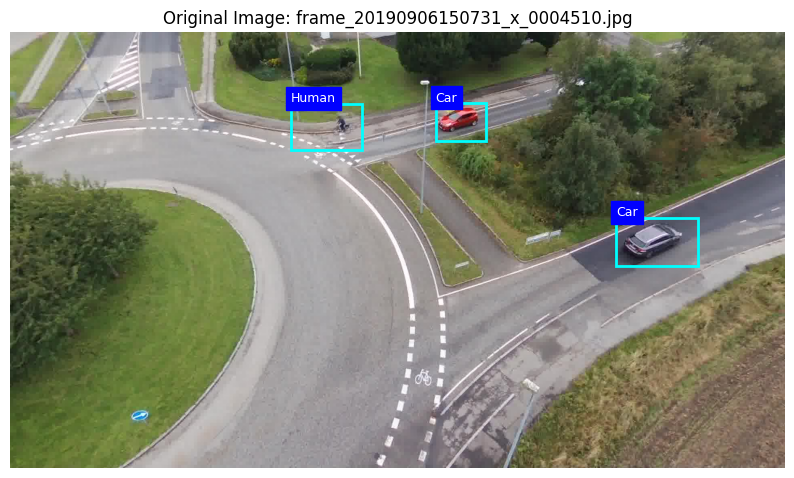

In [15]:
def show_original_image_with_boxes(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)

    entry = dataset.entries[index]
    image_path = os.path.join(dataset.image_dir, entry["image_name"])
    image = Image.open(image_path).convert("RGB")

    boxes = []
    class_labels = []

    for obj in entry["bbox"]:
        x_min = obj["left"]
        y_min = obj["top"]
        x_max = x_min + obj["width"]
        y_max = y_min + obj["height"]
        boxes.append([x_min, y_min, x_max, y_max])
        class_labels.append(obj["class"])

    image_np = np.array(image)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_np)

    for box, label in zip(boxes, class_labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"{dataset.class_names[label]}",
                color='white', backgroundcolor='blue', fontsize=9)

    ax.set_title(f"Original Image: {entry['image_name']}")
    plt.axis("off")
    plt.show()

for _ in range(1):
    show_original_image_with_boxes(dataset)


## Format Predictions and Ground Truth in COCO Style
Converts predictions from model output (boxes, labels, scores) to COCO detection format. Converts ground truth from normalized center-based format to COCO absolute box format using original image size.

In [16]:
def prepare_coco_format(results, labels_batch, image_id_counter, ann_id_counter):
    """
    Formats model predictions and ground truth labels for a batch into COCO style lists.
    Handles normalized cxcywh format for ground truth boxes.
    """
    coco_results = []     
    coco_annotations = [] 
    coco_images = []      

    for j, (result, gt_label_dict) in enumerate(zip(results, labels_batch)):
        image_id = image_id_counter + j
        coco_images.append({"id": image_id})

        pred_boxes = result["boxes"].cpu().numpy()
        pred_scores = result["scores"].cpu().numpy()
        pred_labels = result["labels"].cpu().numpy()

        for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            if width > 0 and height > 0:
                coco_results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [float(x_min), float(y_min), float(width), float(height)],
                    "score": float(score),
                })

        try:
            orig_size = gt_label_dict['orig_size'].cpu().tolist()
            orig_h, orig_w = orig_size[0], orig_size[1]

            gt_boxes_normalized = gt_label_dict["boxes"].cpu().numpy()
            gt_labels = gt_label_dict["class_labels"].cpu().numpy()

            for box_norm, label in zip(gt_boxes_normalized, gt_labels):
                cx_norm, cy_norm, w_norm, h_norm = box_norm

                center_x = cx_norm * orig_w
                center_y = cy_norm * orig_h
                box_width = w_norm * orig_w
                box_height = h_norm * orig_h

                xmin = center_x - (box_width / 2)
                ymin = center_y - (box_height / 2)

                if box_width > 0 and box_height > 0:
                    coco_annotations.append({
                        "id": ann_id_counter,
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [float(xmin), float(ymin), float(box_width), float(box_height)],
                        "area": float(box_width * box_height),
                        "iscrowd": 0,
                    })
                    ann_id_counter += 1 
                else:
                    print(f"Warning: Skipping GT annotation with invalid calculated dimensions (w={box_width}, h={box_height}) for image_id {image_id}")

        except KeyError as e:
            print(f"Error processing ground truth for image_id {image_id}: Missing key {e}. Skipping GT.")
            continue
        except Exception as e:
            print(f"Error processing ground truth for image_id {image_id}: {e}. Skipping GT.")
            continue

    return coco_results, coco_annotations, coco_images, ann_id_counter

## DETR Evaluation with COCO Metrics and Per-Class AP

In [17]:
def evaluate_detr(model, processor, val_loader, id2label, device):
    model.eval()
    val_loss = 0
    all_results, all_annotations, all_images = [], [], []
    ann_id_counter = 1
    image_id_counter = 0
    per_class_ap_dict = {name: 0.0 for name in id2label.values()} # Initialize dict

    with torch.no_grad():
        for i, val_batch in enumerate(val_loader):

            pixel_values = val_batch["pixel_values"].to(device)
            # labels = [{k: v.to(device) for k, v in t.items()} for t in val_batch["labels"]]
            labels_for_loss = [{k: v.to(device) for k, v in t.items()} for t in val_batch["labels"]]
            ground_truth_labels = val_batch["labels"] 
            outputs = model(pixel_values=pixel_values, labels=labels_for_loss)
            val_loss += outputs.loss.item()
            
            
            if i % 100 == 0:
                avg_val_loss = val_loss / (i + 1)

            target_sizes = torch.stack(val_batch["orig_size"]).to(device)
            pred_outputs = model(pixel_values=pixel_values)
            results = processor.post_process_object_detection(pred_outputs, threshold=0.05, target_sizes=target_sizes)

            res, anns, imgs, ann_id_counter = prepare_coco_format(results, 
                                                                  ground_truth_labels, 
                                                                  image_id_counter, 
                                                                  ann_id_counter)
            all_results.extend(res)
            all_annotations.extend(anns)
            all_images.extend(imgs)

            image_id_counter += len(pixel_values)

    coco_gt = {
        "images": all_images,
        "annotations": all_annotations,
        "categories": [{"id": i, "name": name} for i, name in id2label.items()],
    }

    with tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as f_gt, \
         tempfile.NamedTemporaryFile(mode="w+", suffix=".json", delete=False) as f_dt:

        json.dump(coco_gt, f_gt)
        f_gt.flush()
        json.dump(all_results, f_dt)
        f_dt.flush()

        coco = COCO(f_gt.name)
        coco_dt = coco.loadRes(f_dt.name)

        coco_eval = COCOeval(coco, coco_dt, iouType="bbox")
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        mAP = coco_eval.stats[0]
        precision = coco_eval.eval['precision']
        
        ap_params = coco_eval.params

        cat_ids = sorted(id2label.keys())
        if cat_ids != list(range(8)):
            print("Warning: Category IDs in id2label might not match 0..N-1 indices used by COCOeval.")

        for k_idx, cat_id in enumerate(cat_ids): 
            class_name = id2label[cat_id]
            p = precision[:, :, k_idx, 0, 2]
            ap = np.mean(p[p > -1]) if np.any(p > -1) else 0.0
            per_class_ap_dict[class_name] = ap
            print(f"- {class_name:<15}: {ap:.4f}")

    os.remove(f_gt.name)
    os.remove(f_dt.name)

    return val_loss / len(val_loader), mAP


## W&B Initialization

In [18]:
import time
import wandb

wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ovguyo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Optimizer, Scheduler, and Weights & Biases (W&B) Setup

In [19]:
epochs = 20
log_interval = 250
eval_interval = 500
iter_num = 0
best_map = 0.0

optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-5, weight_decay=1e-4)

# CosineAnnealingLR: Smoothly reduces the learning rate to a minimum value over epochs.
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-7) 

config_wandb = {
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0]['weight_decay'], 
    "epochs": epochs,
    "batch_size": train_loader.batch_size if hasattr(train_loader, 'batch_size') else 'N/A',
    "log_interval": log_interval,
    "eval_interval": eval_interval,
    "architecture": model.config.model_type if hasattr(model, 'config') else "DETR-variant",
    "grad_clip_norm": 0.1 
}

run_name = f"detr-run-{time.strftime('%Y%m%d-%H%M%S')}"
wandb.init(
    project="detr-aerial-detection", 
    config=config_wandb,
    name=run_name, 
    reinit=True  
)
print(f"Wandb run initialized: {run_name}")

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Wandb run initialized: detr-run-20250419-202640


## Full Training Loop
This cell contains the complete training loop for fine-tuning the DETR model on the AUAIR dataset. Runs evaluate_detr every eval_interval steps. Logs validation loss and mAP to W&B. Saves model checkpoints when a new best mAP is achieved.

In [20]:
try:
    for epoch in range(epochs):
            model.train()
            total_loss = 0
            running_loss = 0

            print(f"\nEpoch {epoch+1}/{epochs}")
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training", unit="batch")

            for batch in progress_bar:
                pixel_values = batch["pixel_values"].to(device)
                labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

                outputs = model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config_wandb["grad_clip_norm"])
                optimizer.step()

                total_loss += loss.item()
                running_loss += loss.item()
                iter_num += 1

                if iter_num % log_interval == 0:
                    avg_interval_loss = running_loss / log_interval
                    wandb.log({
                            "train/loss_log_interval": avg_interval_loss, 
                            "learning_rate": optimizer.param_groups[0]['lr'],
                            "step": iter_num
                            })
                    progress_bar.set_postfix({"loss": f"{avg_interval_loss:.4f}"})
                    running_loss = 0

                if iter_num % eval_interval == 0:
                    val_loss, mAP = evaluate_detr(model, processor, val_loader, id2label, device)
                    
                    # Log metrics to wandb (including the interval train loss)
                    wandb.log({
                        "validation/val_loss": val_loss,
                        "validation/mAP": mAP,
                        "step": iter_num
                    })

                    current_avg_train_loss_run = total_loss / iter_num # Avg loss over entire run so far
                    print(f"\nStep {iter_num}: Train Loss (Run Avg): {current_avg_train_loss_run:.4f},  Val Loss: {val_loss:.4f}, mAP: {mAP:.4f}")

                    if mAP > best_map:
                        best_map = mAP
                        wandb.summary["best_mAP"] = best_map 
                        save_path = f"best_detr_model_step_{iter_num}_map_{best_map:.4f}.pth"
                        torch.save(model.state_dict(), save_path)
                        print(f"  Saved new best model to {save_path}")


                    model.train()

            avg_epoch_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1} completed. Average Training Loss: {avg_epoch_loss:.4f}")
            wandb.log({
                "train/loss_epoch": avg_epoch_loss,
                "epoch": epoch + 1 
            })

    print("Training finished.")
    if best_map != -1.0:
        print(f"Best mAP achieved: {best_map:.4f}")
        
except Exception as e:
    print(f"\nAn error occurred during the training loop: {e}")
    try:
        wandb.log({"error": str(e)})
    except Exception as wb_err:
        print(f"Could not log error to wandb: {wb_err}")
    raise 

finally:
    print("\nFinishing wandb run...")
    if wandb.run is not None:
        wandb.finish()
        print("Wandb run finished.")
    else:
        print("No active wandb run to finish.")


Epoch 1/20


Epoch 1 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 1 Training:  17%|█████████████████████████▏                                                                                                                       | 499/2871 [03:50<17:12,  2.30batch/s, loss=2.0963]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=16.95s).
Accumulating evaluation results...
DONE (t=6.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 1 Training:  17%|████████████████████████▋                                                                                                                     | 500/2871 [08:48<59:13:53, 89.93s/batch, loss=2.0963]


Step 500: Train Loss (Run Avg): 2.3560,  Val Loss: 1.8629, mAP: 0.0060
  Saved new best model to best_detr_model_step_500_map_0.0060.pth


Epoch 1 Training:  35%|██████████████████████████████████████████████████▍                                                                                              | 999/2871 [12:21<14:01,  2.23batch/s, loss=1.8946]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.79s).
Accumulating evaluation results...


Epoch 1 Training:  35%|█████████████████████████████████████████████████                                                                                            | 1000/2871 [16:52<42:27:55, 81.71s/batch, loss=1.8946]

DONE (t=1.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.050
- Human          : 0.000

Epoch 1 Training:  52%|███████████████████████████████████████████████████████████████████████████▏                                                                    | 1499/2871 [20:32<09:32,  2.40batch/s, loss=1.8616]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.56s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.47s).
Accumulating evaluation results...
DONE (t=1.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 1 Training:  52%|█████████████████████████████████████████████████████████████████████████▋                                                                   | 1500/2871 [24:59<30:38:09, 80.44s/batch, loss=1.8616]

  Saved new best model to best_detr_model_step_1500_map_0.0073.pth


Epoch 1 Training:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1999/2871 [28:28<06:04,  2.39batch/s, loss=1.8339]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.88s).
Accumulating evaluation results...


Epoch 1 Training:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2000/2871 [32:55<19:27:45, 80.44s/batch, loss=1.8339]

DONE (t=1.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.052
- Human          : 0.000

Epoch 1 Training:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2499/2871 [36:24<02:36,  2.38batch/s, loss=1.7660]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.25s).
Accumulating evaluation results...


Epoch 1 Training:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2500/2871 [41:10<8:52:20, 86.09s/batch, loss=1.7660]

DONE (t=1.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.054
- Human          : 0.000

Epoch 1 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [43:45<00:00,  1.09batch/s, loss=1.7756]


Epoch 1 completed. Average Training Loss: 1.9426

Epoch 2/20


Epoch 2 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 2 Training:   4%|██████▍                                                                                                                                          | 128/2871 [00:55<19:04,  2.40batch/s, loss=0.9025]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.48s).
Accumulating evaluation results...


Epoch 2 Training:   4%|██████▍                                                                                                                                       | 129/2871 [05:15<59:52:13, 78.60s/batch, loss=0.9025]

DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.051
- Human          : 0.000

Epoch 2 Training:  22%|███████████████████████████████▋                                                                                                                 | 628/2871 [08:45<15:37,  2.39batch/s, loss=1.7407]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.44s).
Accumulating evaluation results...


Epoch 2 Training:  22%|███████████████████████████████                                                                                                               | 629/2871 [13:18<51:19:39, 82.42s/batch, loss=1.7407]

DONE (t=1.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.053
- Human          : 0.000

Epoch 2 Training:  39%|████████████████████████████████████████████████████████▌                                                                                       | 1128/2871 [16:55<12:09,  2.39batch/s, loss=1.7269]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.70s).
Accumulating evaluation results...
DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 2 Training:  39%|███████████████████████████████████████████████████████▍                                                                                     | 1129/2871 [21:17<38:12:58, 78.98s/batch, loss=1.7269]

  Saved new best model to best_detr_model_step_4000_map_0.0083.pth


Epoch 2 Training:  57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1628/2871 [24:46<09:01,  2.30batch/s, loss=1.6532]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.35s).
Accumulating evaluation results...


Epoch 2 Training:  57%|████████████████████████████████████████████████████████████████████████████████                                                             | 1629/2871 [29:08<27:17:18, 79.10s/batch, loss=1.6532]

DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
- Human          : 0.000

Epoch 2 Training:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2128/2871 [32:38<05:11,  2.39batch/s, loss=1.6543]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.58s).
Accumulating evaluation results...
DONE (t=1.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 2 Training:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2129/2871 [36:56<16:00:58, 77.71s/batch, loss=1.6543]

  Saved new best model to best_detr_model_step_5000_map_0.0123.pth


Epoch 2 Training:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2628/2871 [40:25<01:41,  2.39batch/s, loss=1.6764]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.32s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.04s).
Accumulating evaluation results...


Epoch 2 Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2629/2871 [44:47<5:18:47, 79.04s/batch, loss=1.6764]

DONE (t=1.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
- Human          : 0.000

Epoch 2 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:28<00:00,  1.03batch/s, loss=1.6764]


Epoch 2 completed. Average Training Loss: 1.6883

Epoch 3/20


Epoch 3 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 3 Training:   9%|████████████▉                                                                                                                                    | 257/2871 [01:49<18:14,  2.39batch/s, loss=1.5930]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.47s).
Accumulating evaluation results...
DONE (t=1.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 3 Training:   9%|████████████▊                                                                                                                                 | 258/2871 [06:13<57:48:34, 79.65s/batch, loss=1.5930]

  Saved new best model to best_detr_model_step_6000_map_0.0129.pth


Epoch 3 Training:  26%|██████████████████████████████████████▏                                                                                                          | 757/2871 [09:43<14:46,  2.38batch/s, loss=1.6336]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.95s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.99s).
Accumulating evaluation results...


Epoch 3 Training:  26%|█████████████████████████████████████▍                                                                                                        | 758/2871 [14:03<46:01:48, 78.42s/batch, loss=1.6336]

DONE (t=1.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.089
- Human          : 0.002

Epoch 3 Training:  44%|███████████████████████████████████████████████████████████████                                                                                 | 1257/2871 [17:32<11:14,  2.39batch/s, loss=1.6357]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.45s).
Accumulating evaluation results...
DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 3 Training:  44%|█████████████████████████████████████████████████████████████▊                                                                               | 1258/2871 [21:53<35:19:15, 78.83s/batch, loss=1.6357]

  Saved new best model to best_detr_model_step_7000_map_0.0155.pth


Epoch 3 Training:  61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1757/2871 [25:22<07:46,  2.39batch/s, loss=1.6301]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.73s).
Accumulating evaluation results...


Epoch 3 Training:  61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1758/2871 [29:42<24:15:28, 78.46s/batch, loss=1.6301]

DONE (t=1.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
- Human          : 0.007

Epoch 3 Training:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2257/2871 [33:11<04:16,  2.39batch/s, loss=1.6204]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.42s).
Accumulating evaluation results...
DONE (t=1.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 3 Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2258/2871 [37:34<13:29:20, 79.22s/batch, loss=1.6204]

  Saved new best model to best_detr_model_step_8000_map_0.0182.pth


Epoch 3 Training:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2757/2871 [41:03<00:47,  2.39batch/s, loss=1.6199]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.61s).
Accumulating evaluation results...


Epoch 3 Training:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2758/2871 [45:26<2:29:30, 79.38s/batch, loss=1.6199]

DONE (t=1.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
- Human          : 0.014

Epoch 3 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:13<00:00,  1.04batch/s, loss=1.6199]


Epoch 3 completed. Average Training Loss: 1.6181

Epoch 4/20


Epoch 4 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 4 Training:  13%|███████████████████▍                                                                                                                             | 386/2871 [02:43<17:19,  2.39batch/s, loss=1.5557]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.80s).
Accumulating evaluation results...
DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4 Training:  13%|███████████████████▏                                                                                                                          | 387/2871 [07:02<54:02:36, 78.32s/batch, loss=1.5557]

  Saved new best model to best_detr_model_step_9000_map_0.0202.pth


Epoch 4 Training:  31%|████████████████████████████████████████████▋                                                                                                    | 886/2871 [10:33<13:59,  2.36batch/s, loss=1.5321]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.73s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.28s).
Accumulating evaluation results...
DONE (t=1.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4 Training:  31%|███████████████████████████████████████████▊                                                                                                  | 887/2871 [14:52<43:10:47, 78.35s/batch, loss=1.5321]

  Saved new best model to best_detr_model_step_9500_map_0.0224.pth


Epoch 4 Training:  48%|█████████████████████████████████████████████████████████████████████▌                                                                          | 1386/2871 [18:30<10:28,  2.36batch/s, loss=1.5759]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.27s).
Accumulating evaluation results...
DONE (t=2.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 4 Training:  48%|████████████████████████████████████████████████████████████████████                                                                         | 1387/2871 [23:06<34:16:04, 83.13s/batch, loss=1.5759]


Step 10000: Train Loss (Run Avg): 0.2167,  Val Loss: 1.5298, mAP: 0.0268
  Saved new best model to best_detr_model_step_10000_map_0.0268.pth


Epoch 4 Training:  66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1886/2871 [26:45<07:31,  2.18batch/s, loss=1.5464]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.51s).
Accumulating evaluation results...


Epoch 4 Training:  66%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1887/2871 [31:12<22:02:10, 80.62s/batch, loss=1.5464]

DONE (t=1.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.141
- Human          : 0.022

Epoch 4 Training:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2386/2871 [34:51<03:41,  2.19batch/s, loss=1.6038]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.23s).
Accumulating evaluation results...
DONE (t=1.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.075
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4 Training:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2387/2871 [39:21<10:56:53, 81.43s/batch, loss=1.6038]

  Saved new best model to best_detr_model_step_11000_map_0.0269.pth


Epoch 4 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [42:53<00:00,  1.12batch/s, loss=1.5797]


Epoch 4 completed. Average Training Loss: 1.5655

Epoch 5/20


Epoch 5 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 5 Training:   1%|▊                                                                                                                                                 | 15/2871 [00:08<20:50,  2.28batch/s, loss=0.0938]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.57s).
Accumulating evaluation results...


Epoch 5 Training:   1%|▊                                                                                                                                              | 16/2871 [04:39<65:11:27, 82.20s/batch, loss=0.0938]

DONE (t=1.86s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.131
- Human          : 0.017

Epoch 5 Training:  18%|██████████████████████████                                                                                                                       | 515/2871 [08:10<16:25,  2.39batch/s, loss=1.5454]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.94s).
Accumulating evaluation results...
DONE (t=1.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 5 Training:  18%|█████████████████████████▌                                                                                                                    | 516/2871 [12:33<51:59:26, 79.48s/batch, loss=1.5454]

  Saved new best model to best_detr_model_step_12000_map_0.0283.pth


Epoch 5 Training:  35%|██████████████████████████████████████████████████▉                                                                                             | 1015/2871 [16:03<13:47,  2.24batch/s, loss=1.5102]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.81s).
Accumulating evaluation results...
DONE (t=1.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 5 Training:  35%|█████████████████████████████████████████████████▉                                                                                           | 1016/2871 [20:24<40:35:45, 78.78s/batch, loss=1.5102]

  Saved new best model to best_detr_model_step_12500_map_0.0325.pth


Epoch 5 Training:  53%|███████████████████████████████████████████████████████████████████████████▉                                                                    | 1515/2871 [23:54<09:27,  2.39batch/s, loss=1.5287]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.86s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.61s).
Accumulating evaluation results...


Epoch 5 Training:  53%|██████████████████████████████████████████████████████████████████████████▍                                                                  | 1516/2871 [28:12<29:11:41, 77.57s/batch, loss=1.5287]

DONE (t=1.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.155
- Human          : 0.025

Epoch 5 Training:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2015/2871 [31:42<05:58,  2.39batch/s, loss=1.5172]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.90s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.43s).
Accumulating evaluation results...
DONE (t=1.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 5 Training:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2016/2871 [36:00<18:30:41, 77.94s/batch, loss=1.5172]

  Saved new best model to best_detr_model_step_13500_map_0.0347.pth


Epoch 5 Training:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2515/2871 [39:31<02:29,  2.38batch/s, loss=1.5113]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.32s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.81s).
Accumulating evaluation results...
DONE (t=2.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 5 Training:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2516/2871 [43:53<7:48:19, 79.15s/batch, loss=1.5113]

  Saved new best model to best_detr_model_step_14000_map_0.0351.pth


Epoch 5 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:23<00:00,  1.03batch/s, loss=1.5066]


Epoch 5 completed. Average Training Loss: 1.5172

Epoch 6/20


Epoch 6 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 6 Training:   5%|███████▎                                                                                                                                         | 144/2871 [01:02<19:00,  2.39batch/s, loss=0.8587]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.59s).
Accumulating evaluation results...
DONE (t=1.96s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 6 Training:   5%|███████▏                                                                                                                                      | 145/2871 [05:25<60:10:15, 79.46s/batch, loss=0.8587]

  Saved new best model to best_detr_model_step_14500_map_0.0382.pth


Epoch 6 Training:  22%|████████████████████████████████▌                                                                                                                | 644/2871 [09:02<17:25,  2.13batch/s, loss=1.4949]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.46s).
Accumulating evaluation results...


Epoch 6 Training:  22%|███████████████████████████████▉                                                                                                              | 645/2871 [13:34<50:45:05, 82.08s/batch, loss=1.4949]

DONE (t=1.82s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.179
- Human          : 0.045

Epoch 6 Training:  40%|█████████████████████████████████████████████████████████▍                                                                                      | 1144/2871 [17:13<12:04,  2.38batch/s, loss=1.4605]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.95s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.67s).
Accumulating evaluation results...


Epoch 6 Training:  40%|████████████████████████████████████████████████████████▏                                                                                    | 1145/2871 [21:49<39:47:56, 83.01s/batch, loss=1.4605]

DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.179
- Human          : 0.054

Epoch 6 Training:  57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1644/2871 [25:29<08:32,  2.40batch/s, loss=1.5006]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.33s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.19s).
Accumulating evaluation results...
DONE (t=1.58s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 6 Training:  57%|████████████████████████████████████████████████████████████████████████████████▊                                                            | 1645/2871 [30:01<27:55:28, 82.00s/batch, loss=1.5006]

  Saved new best model to best_detr_model_step_16000_map_0.0409.pth


Epoch 6 Training:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2144/2871 [33:35<05:02,  2.40batch/s, loss=1.4713]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.43s).
Accumulating evaluation results...


Epoch 6 Training:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2145/2871 [37:57<15:56:06, 79.02s/batch, loss=1.4713]

DONE (t=1.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.179
- Human          : 0.053

Epoch 6 Training:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2644/2871 [41:27<01:35,  2.39batch/s, loss=1.4898]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.68s).
Accumulating evaluation results...
DONE (t=1.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 6 Training:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2645/2871 [45:46<4:54:11, 78.11s/batch, loss=1.4898]

  Saved new best model to best_detr_model_step_17000_map_0.0427.pth


Epoch 6 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [47:20<00:00,  1.01batch/s, loss=1.4898]


Epoch 6 completed. Average Training Loss: 1.4876

Epoch 7/20


Epoch 7 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 7 Training:  10%|█████████████▊                                                                                                                                   | 273/2871 [01:56<18:11,  2.38batch/s, loss=1.5098]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.85s).
Accumulating evaluation results...
DONE (t=1.61s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 7 Training:  10%|█████████████▌                                                                                                                                | 274/2871 [06:16<56:34:59, 78.44s/batch, loss=1.5098]

  Saved new best model to best_detr_model_step_17500_map_0.0457.pth


Epoch 7 Training:  27%|███████████████████████████████████████                                                                                                          | 773/2871 [09:45<14:37,  2.39batch/s, loss=1.4509]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.89s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.31s).
Accumulating evaluation results...


Epoch 7 Training:  27%|██████████████████████████████████████▎                                                                                                       | 774/2871 [14:03<45:20:03, 77.83s/batch, loss=1.4509]

DONE (t=1.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.181
- Human          : 0.066

Epoch 7 Training:  44%|███████████████████████████████████████████████████████████████▊                                                                                | 1273/2871 [17:32<11:06,  2.40batch/s, loss=1.4511]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.10s).
Accumulating evaluation results...
DONE (t=1.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 7 Training:  44%|██████████████████████████████████████████████████████████████▌                                                                              | 1274/2871 [21:51<34:42:14, 78.23s/batch, loss=1.4511]

  Saved new best model to best_detr_model_step_18500_map_0.0462.pth


Epoch 7 Training:  62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1773/2871 [25:20<07:38,  2.39batch/s, loss=1.4709]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.99s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.21s).
Accumulating evaluation results...


Epoch 7 Training:  62%|███████████████████████████████████████████████████████████████████████████████████████                                                      | 1774/2871 [29:40<23:52:56, 78.37s/batch, loss=1.4709]

DONE (t=1.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.190
- Human          : 0.071

Epoch 7 Training:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2273/2871 [33:09<04:09,  2.39batch/s, loss=1.4434]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.35s).
Accumulating evaluation results...


Epoch 7 Training:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2274/2871 [37:29<13:00:22, 78.43s/batch, loss=1.4434]

DONE (t=1.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.193
- Human          : 0.065

Epoch 7 Training:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2773/2871 [40:58<00:41,  2.37batch/s, loss=1.4963]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.87s).
Accumulating evaluation results...


Epoch 7 Training:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2774/2871 [45:18<2:06:34, 78.29s/batch, loss=1.4963]

DONE (t=1.97s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.180
- Human          : 0.069

Epoch 7 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:58<00:00,  1.04batch/s, loss=1.4963]


Epoch 7 completed. Average Training Loss: 1.4588

Epoch 8/20


Epoch 8 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 8 Training:  14%|████████████████████▎                                                                                                                            | 402/2871 [02:50<17:14,  2.39batch/s, loss=1.4608]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.22s).
Accumulating evaluation results...


Epoch 8 Training:  14%|███████████████████▉                                                                                                                          | 403/2871 [07:09<53:37:33, 78.22s/batch, loss=1.4608]

DONE (t=1.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.179
- Human          : 0.061

Epoch 8 Training:  31%|█████████████████████████████████████████████▌                                                                                                   | 902/2871 [10:38<13:42,  2.39batch/s, loss=1.4751]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.09s).
Accumulating evaluation results...


Epoch 8 Training:  31%|████████████████████████████████████████████▋                                                                                                 | 903/2871 [14:56<42:37:06, 77.96s/batch, loss=1.4751]

DONE (t=1.98s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.061
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.165
- Human          : 0.050

Epoch 8 Training:  49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 1402/2871 [18:25<10:12,  2.40batch/s, loss=1.4811]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.78s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.01s).
Accumulating evaluation results...


Epoch 8 Training:  49%|████████████████████████████████████████████████████████████████████▉                                                                        | 1403/2871 [22:41<31:24:06, 77.01s/batch, loss=1.4811]

DONE (t=1.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
- Human          : 0.054

Epoch 8 Training:  66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1902/2871 [26:10<06:45,  2.39batch/s, loss=1.4295]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.89s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.15s).
Accumulating evaluation results...


Epoch 8 Training:  66%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1903/2871 [30:27<20:52:56, 77.66s/batch, loss=1.4295]

DONE (t=1.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.188
- Human          : 0.077

Epoch 8 Training:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2402/2871 [33:56<03:15,  2.40batch/s, loss=1.4809]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.10s).
Accumulating evaluation results...


Epoch 8 Training:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2403/2871 [38:16<10:10:41, 78.29s/batch, loss=1.4809]

DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.188
- Human          : 0.070

Epoch 8 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [41:31<00:00,  1.15batch/s, loss=1.4849]


Epoch 8 completed. Average Training Loss: 1.4591

Epoch 9/20


Epoch 9 Training:   0%|                                                                                                                                                                        | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 9 Training:   1%|█▌                                                                                                                                                | 31/2871 [00:14<19:48,  2.39batch/s, loss=0.1794]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.87s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.23s).
Accumulating evaluation results...


Epoch 9 Training:   1%|█▌                                                                                                                                             | 32/2871 [04:32<61:18:41, 77.75s/batch, loss=0.1794]

DONE (t=1.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
- Human          : 0.063

Epoch 9 Training:  18%|██████████████████████████▊                                                                                                                      | 531/2871 [08:01<16:17,  2.39batch/s, loss=1.4447]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.02s).
Accumulating evaluation results...


Epoch 9 Training:  19%|██████████████████████████▎                                                                                                                   | 532/2871 [12:20<50:48:37, 78.20s/batch, loss=1.4447]

DONE (t=1.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.196
- Human          : 0.078

Epoch 9 Training:  36%|███████████████████████████████████████████████████▋                                                                                            | 1031/2871 [15:49<12:48,  2.39batch/s, loss=1.4595]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.72s).
Accumulating evaluation results...
DONE (t=1.57s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 9 Training:  36%|██████████████████████████████████████████████████▋                                                                                          | 1032/2871 [20:08<39:52:01, 78.04s/batch, loss=1.4595]

  Saved new best model to best_detr_model_step_24000_map_0.0482.pth


Epoch 9 Training:  53%|████████████████████████████████████████████████████████████████████████████▊                                                                   | 1531/2871 [23:37<09:19,  2.39batch/s, loss=1.4384]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.87s).
Accumulating evaluation results...
DONE (t=1.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 9 Training:  53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 1532/2871 [27:59<29:25:29, 79.11s/batch, loss=1.4384]

  Saved new best model to best_detr_model_step_24500_map_0.0485.pth


Epoch 9 Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2031/2871 [31:28<05:53,  2.38batch/s, loss=1.4550]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.95s).
Accumulating evaluation results...


Epoch 9 Training:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2032/2871 [35:50<18:22:56, 78.88s/batch, loss=1.4550]

DONE (t=1.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.193
- Human          : 0.075

Epoch 9 Training:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2531/2871 [39:19<02:21,  2.40batch/s, loss=1.4509]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.02s).
Accumulating evaluation results...


Epoch 9 Training:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2532/2871 [43:38<7:21:31, 78.15s/batch, loss=1.4509]

DONE (t=1.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.183
- Human          : 0.077

Epoch 9 Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:59<00:00,  1.04batch/s, loss=1.4216]


Epoch 9 completed. Average Training Loss: 1.4459

Epoch 10/20


Epoch 10 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 10 Training:   6%|████████                                                                                                                                        | 160/2871 [01:08<18:53,  2.39batch/s, loss=0.9210]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.83s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.69s).
Accumulating evaluation results...


Epoch 10 Training:   6%|███████▉                                                                                                                                     | 161/2871 [05:25<58:19:35, 77.48s/batch, loss=0.9210]

DONE (t=1.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.197
- Human          : 0.070

Epoch 10 Training:  23%|█████████████████████████████████                                                                                                               | 660/2871 [08:54<15:25,  2.39batch/s, loss=1.4536]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.52s).
Accumulating evaluation results...
DONE (t=1.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 10 Training:  23%|████████████████████████████████▍                                                                                                            | 661/2871 [13:11<47:35:02, 77.51s/batch, loss=1.4536]

  Saved new best model to best_detr_model_step_26500_map_0.0495.pth


Epoch 10 Training:  40%|█████████████████████████████████████████████████████████▊                                                                                     | 1160/2871 [16:40<11:56,  2.39batch/s, loss=1.4544]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.69s).
Accumulating evaluation results...
DONE (t=1.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 10 Training:  40%|████████████████████████████████████████████████████████▌                                                                                   | 1161/2871 [20:59<37:05:30, 78.09s/batch, loss=1.4544]

  Saved new best model to best_detr_model_step_27000_map_0.0523.pth


Epoch 10 Training:  58%|██████████████████████████████████████████████████████████████████████████████████▋                                                            | 1660/2871 [24:28<08:29,  2.38batch/s, loss=1.4367]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.91s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.30s).
Accumulating evaluation results...
DONE (t=1.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 10 Training:  58%|████████████████████████████████████████████████████████████████████████████████▉                                                           | 1661/2871 [28:46<26:09:39, 77.83s/batch, loss=1.4367]

  Saved new best model to best_detr_model_step_27500_map_0.0527.pth


Epoch 10 Training:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2160/2871 [32:16<04:57,  2.39batch/s, loss=1.4136]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.60s).
Accumulating evaluation results...


Epoch 10 Training:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2161/2871 [36:38<15:35:17, 79.04s/batch, loss=1.4136]

DONE (t=1.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.196
- Human          : 0.065

Epoch 10 Training:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2660/2871 [40:07<01:28,  2.40batch/s, loss=1.3973]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.10s).
Accumulating evaluation results...


Epoch 10 Training:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2661/2871 [44:26<4:33:47, 78.23s/batch, loss=1.3973]

DONE (t=1.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.054
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.165
- Human          : 0.042

Epoch 10 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:54<00:00,  1.04batch/s, loss=1.3973]


Epoch 10 completed. Average Training Loss: 1.4371

Epoch 11/20


Epoch 11 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 11 Training:  10%|██████████████▍                                                                                                                                 | 289/2871 [02:02<18:01,  2.39batch/s, loss=1.3972]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.27s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.11s).
Accumulating evaluation results...


Epoch 11 Training:  10%|██████████████▏                                                                                                                              | 290/2871 [06:23<56:26:45, 78.73s/batch, loss=1.3972]

DONE (t=1.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.190
- Human          : 0.069

Epoch 11 Training:  27%|███████████████████████████████████████▌                                                                                                        | 789/2871 [09:52<14:29,  2.39batch/s, loss=1.4440]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.88s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.95s).
Accumulating evaluation results...


Epoch 11 Training:  28%|██████████████████████████████████████▊                                                                                                      | 790/2871 [14:09<44:49:20, 77.54s/batch, loss=1.4440]

DONE (t=1.41s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.195
- Human          : 0.066

Epoch 11 Training:  45%|████████████████████████████████████████████████████████████████▏                                                                              | 1289/2871 [17:38<11:00,  2.40batch/s, loss=1.4500]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.51s).
Accumulating evaluation results...


Epoch 11 Training:  45%|██████████████████████████████████████████████████████████████▉                                                                             | 1290/2871 [21:58<34:27:08, 78.45s/batch, loss=1.4500]

DONE (t=1.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.123
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.196
- Human          : 0.058

Epoch 11 Training:  62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 1789/2871 [25:27<07:31,  2.40batch/s, loss=1.4432]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.99s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.35s).
Accumulating evaluation results...


Epoch 11 Training:  62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1790/2871 [29:47<23:31:36, 78.35s/batch, loss=1.4432]

DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.191
- Human          : 0.082

Epoch 11 Training:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2289/2871 [33:16<04:03,  2.39batch/s, loss=1.4823]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.42s).
Accumulating evaluation results...


Epoch 11 Training:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2290/2871 [37:37<12:40:16, 78.51s/batch, loss=1.4823]

DONE (t=1.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
- Human          : 0.083

Epoch 11 Training:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2789/2871 [41:06<00:34,  2.40batch/s, loss=1.4346]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.32s).
Accumulating evaluation results...


Epoch 11 Training:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2790/2871 [45:24<1:45:15, 77.96s/batch, loss=1.4346]

DONE (t=1.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.187
- Human          : 0.071

Epoch 11 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:58<00:00,  1.04batch/s, loss=1.4346]


Epoch 11 completed. Average Training Loss: 1.4416

Epoch 12/20


Epoch 12 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 12 Training:  15%|████████████████████▉                                                                                                                           | 418/2871 [02:56<17:04,  2.39batch/s, loss=1.4193]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.93s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.57s).
Accumulating evaluation results...


Epoch 12 Training:  15%|████████████████████▌                                                                                                                        | 419/2871 [07:15<53:08:30, 78.02s/batch, loss=1.4193]

DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.196
- Human          : 0.057

Epoch 12 Training:  32%|██████████████████████████████████████████████                                                                                                  | 918/2871 [10:44<13:35,  2.39batch/s, loss=1.4297]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.03s).
Accumulating evaluation results...


Epoch 12 Training:  32%|█████████████████████████████████████████████▏                                                                                               | 919/2871 [15:03<42:27:10, 78.29s/batch, loss=1.4297]

DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.208
- Human          : 0.064

Epoch 12 Training:  49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 1418/2871 [18:32<10:09,  2.38batch/s, loss=1.4428]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.85s).
Accumulating evaluation results...


Epoch 12 Training:  49%|█████████████████████████████████████████████████████████████████████▏                                                                      | 1419/2871 [22:52<31:33:50, 78.26s/batch, loss=1.4428]

DONE (t=1.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.198
- Human          : 0.078

Epoch 12 Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1918/2871 [26:21<06:38,  2.39batch/s, loss=1.4018]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.75s).
Accumulating evaluation results...


Epoch 12 Training:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1919/2871 [30:42<20:48:08, 78.66s/batch, loss=1.4018]

DONE (t=1.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
- Human          : 0.061

Epoch 12 Training:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2418/2871 [34:11<03:09,  2.40batch/s, loss=1.4248]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.31s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.85s).
Accumulating evaluation results...


Epoch 12 Training:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2419/2871 [38:32<9:53:28, 78.78s/batch, loss=1.4248]

DONE (t=1.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.197
- Human          : 0.082

Epoch 12 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [41:41<00:00,  1.15batch/s, loss=1.4012]


Epoch 12 completed. Average Training Loss: 1.4257

Epoch 13/20


Epoch 13 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 13 Training:   2%|██▎                                                                                                                                              | 47/2871 [00:21<19:38,  2.40batch/s, loss=0.2697]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.32s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.64s).
Accumulating evaluation results...
DONE (t=1.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 13 Training:   2%|██▎                                                                                                                                           | 48/2871 [04:41<61:42:54, 78.70s/batch, loss=0.2697]

  Saved new best model to best_detr_model_step_34500_map_0.0555.pth


Epoch 13 Training:  19%|███████████████████████████▍                                                                                                                    | 547/2871 [08:11<16:11,  2.39batch/s, loss=1.4252]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.93s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.63s).
Accumulating evaluation results...


Epoch 13 Training:  19%|██████████████████████████▉                                                                                                                  | 548/2871 [12:29<50:19:35, 77.99s/batch, loss=1.4252]

DONE (t=1.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.193
- Human          : 0.086

Epoch 13 Training:  36%|████████████████████████████████████████████████████▏                                                                                          | 1047/2871 [15:58<12:41,  2.39batch/s, loss=1.4217]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.94s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.79s).
Accumulating evaluation results...


Epoch 13 Training:  37%|███████████████████████████████████████████████████                                                                                         | 1048/2871 [20:17<39:29:41, 77.99s/batch, loss=1.4217]

DONE (t=1.57s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.210
- Human          : 0.091

Epoch 13 Training:  54%|█████████████████████████████████████████████████████████████████████████████                                                                  | 1547/2871 [23:46<09:13,  2.39batch/s, loss=1.4068]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.99s).
Accumulating evaluation results...


Epoch 13 Training:  54%|███████████████████████████████████████████████████████████████████████████▍                                                                | 1548/2871 [28:03<28:32:02, 77.64s/batch, loss=1.4068]

DONE (t=1.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.194
- Human          : 0.076

Epoch 13 Training:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2047/2871 [31:32<05:43,  2.40batch/s, loss=1.3806]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.81s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.56s).
Accumulating evaluation results...


Epoch 13 Training:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2048/2871 [35:49<17:40:55, 77.35s/batch, loss=1.3806]

DONE (t=1.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.194
- Human          : 0.079

Epoch 13 Training:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2547/2871 [39:18<02:15,  2.40batch/s, loss=1.4325]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.15s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.52s).
Accumulating evaluation results...


Epoch 13 Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2548/2871 [43:36<6:59:34, 77.94s/batch, loss=1.4325]

DONE (t=1.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
- Human          : 0.087

Epoch 13 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:51<00:00,  1.04batch/s, loss=1.3947]


Epoch 13 completed. Average Training Loss: 1.4207

Epoch 14/20


Epoch 14 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 14 Training:   6%|████████▊                                                                                                                                       | 176/2871 [01:15<18:45,  2.39batch/s, loss=0.9851]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.10s).
Accumulating evaluation results...


Epoch 14 Training:   6%|████████▋                                                                                                                                    | 177/2871 [05:35<58:32:04, 78.22s/batch, loss=0.9851]

DONE (t=1.58s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.208
- Human          : 0.085

Epoch 14 Training:  24%|█████████████████████████████████▉                                                                                                              | 676/2871 [09:04<15:20,  2.38batch/s, loss=1.4155]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.13s).
Accumulating evaluation results...


Epoch 14 Training:  24%|█████████████████████████████████▏                                                                                                           | 677/2871 [13:23<47:38:35, 78.17s/batch, loss=1.4155]

DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.217
- Human          : 0.085

Epoch 14 Training:  41%|██████████████████████████████████████████████████████████▌                                                                                    | 1176/2871 [16:52<11:50,  2.38batch/s, loss=1.3954]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.24s).
Accumulating evaluation results...


Epoch 14 Training:  41%|█████████████████████████████████████████████████████████▍                                                                                  | 1177/2871 [21:12<36:54:33, 78.44s/batch, loss=1.3954]

DONE (t=1.72s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.224
- Human          : 0.085

Epoch 14 Training:  58%|███████████████████████████████████████████████████████████████████████████████████▍                                                           | 1676/2871 [24:41<08:19,  2.39batch/s, loss=1.3933]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.27s).
Accumulating evaluation results...


Epoch 14 Training:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                          | 1677/2871 [29:01<25:57:46, 78.28s/batch, loss=1.3933]

DONE (t=1.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.191
- Human          : 0.079

Epoch 14 Training:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2176/2871 [32:30<04:50,  2.39batch/s, loss=1.4215]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.42s).
Accumulating evaluation results...


Epoch 14 Training:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2177/2871 [36:50<15:09:20, 78.62s/batch, loss=1.4215]

DONE (t=2.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.207
- Human          : 0.072

Epoch 14 Training:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2676/2871 [40:20<01:21,  2.39batch/s, loss=1.4243]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.62s).
Accumulating evaluation results...
DONE (t=1.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 14 Training:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2677/2871 [44:40<4:13:44, 78.48s/batch, loss=1.4243]

  Saved new best model to best_detr_model_step_40000_map_0.0569.pth


Epoch 14 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:01<00:00,  1.04batch/s, loss=1.4243]


Epoch 14 completed. Average Training Loss: 1.4150

Epoch 15/20


Epoch 15 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 15 Training:  11%|███████████████▎                                                                                                                                | 305/2871 [02:09<17:54,  2.39batch/s, loss=1.4258]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.71s).
Accumulating evaluation results...


Epoch 15 Training:  11%|███████████████                                                                                                                              | 306/2871 [06:32<56:26:24, 79.21s/batch, loss=1.4258]

DONE (t=1.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
- Human          : 0.079

Epoch 15 Training:  28%|████████████████████████████████████████▍                                                                                                       | 805/2871 [10:01<14:26,  2.38batch/s, loss=1.3901]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.54s).
Accumulating evaluation results...


Epoch 15 Training:  28%|███████████████████████████████████████▌                                                                                                     | 806/2871 [14:20<44:45:51, 78.04s/batch, loss=1.3901]

DONE (t=1.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.224
- Human          : 0.076

Epoch 15 Training:  45%|█████████████████████████████████████████████████████████████████                                                                              | 1305/2871 [17:49<10:53,  2.40batch/s, loss=1.4301]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.95s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.74s).
Accumulating evaluation results...


Epoch 15 Training:  45%|███████████████████████████████████████████████████████████████▋                                                                            | 1306/2871 [22:07<33:56:16, 78.07s/batch, loss=1.4301]

DONE (t=1.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.212
- Human          : 0.083

Epoch 15 Training:  63%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1805/2871 [25:37<07:25,  2.40batch/s, loss=1.4294]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.89s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.21s).
Accumulating evaluation results...


Epoch 15 Training:  63%|████████████████████████████████████████████████████████████████████████████████████████                                                    | 1806/2871 [29:54<22:59:55, 77.74s/batch, loss=1.4294]

DONE (t=1.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.207
- Human          : 0.079

Epoch 15 Training:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2305/2871 [33:23<03:56,  2.40batch/s, loss=1.4027]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.85s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.95s).
Accumulating evaluation results...


Epoch 15 Training:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2306/2871 [37:40<12:10:22, 77.56s/batch, loss=1.4027]

DONE (t=1.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
- Human          : 0.087

Epoch 15 Training:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2805/2871 [41:10<00:27,  2.39batch/s, loss=1.3795]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.98s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.04s).
Accumulating evaluation results...


Epoch 15 Training:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2806/2871 [45:29<1:24:45, 78.24s/batch, loss=1.3795]

DONE (t=1.61s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.208
- Human          : 0.080

Epoch 15 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:56<00:00,  1.04batch/s, loss=1.3795]


Epoch 15 completed. Average Training Loss: 1.4076

Epoch 16/20


Epoch 16 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 16 Training:  15%|█████████████████████▊                                                                                                                          | 434/2871 [03:03<16:59,  2.39batch/s, loss=1.3853]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.31s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.59s).
Accumulating evaluation results...


Epoch 16 Training:  15%|█████████████████████▎                                                                                                                       | 435/2871 [07:25<53:28:02, 79.02s/batch, loss=1.3853]

DONE (t=1.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.217
- Human          : 0.083

Epoch 16 Training:  33%|██████████████████████████████████████████████▊                                                                                                 | 934/2871 [10:54<13:30,  2.39batch/s, loss=1.4567]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.21s).
Accumulating evaluation results...


Epoch 16 Training:  33%|█████████████████████████████████████████████▉                                                                                               | 935/2871 [15:17<42:37:42, 79.27s/batch, loss=1.4567]

DONE (t=1.91s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.207
- Human          : 0.073

Epoch 16 Training:  50%|███████████████████████████████████████████████████████████████████████▍                                                                       | 1434/2871 [18:46<10:00,  2.39batch/s, loss=1.4426]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.93s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.59s).
Accumulating evaluation results...


Epoch 16 Training:  50%|█████████████████████████████████████████████████████████████████████▉                                                                      | 1435/2871 [23:04<31:03:13, 77.85s/batch, loss=1.4426]

DONE (t=1.49s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.215
- Human          : 0.075

Epoch 16 Training:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1934/2871 [26:33<06:31,  2.40batch/s, loss=1.4256]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.60s).
Accumulating evaluation results...


Epoch 16 Training:  67%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1935/2871 [30:53<20:23:13, 78.41s/batch, loss=1.4256]

DONE (t=1.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.208
- Human          : 0.085

Epoch 16 Training:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2434/2871 [34:22<03:02,  2.39batch/s, loss=1.4281]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.93s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.81s).
Accumulating evaluation results...


Epoch 16 Training:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2435/2871 [38:40<9:26:47, 78.00s/batch, loss=1.4281]

DONE (t=1.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.207
- Human          : 0.062

Epoch 16 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [41:43<00:00,  1.15batch/s, loss=1.3878]


Epoch 16 completed. Average Training Loss: 1.4152

Epoch 17/20


Epoch 17 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 17 Training:   2%|███▏                                                                                                                                             | 63/2871 [00:28<19:32,  2.39batch/s, loss=0.3664]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.48s).
Accumulating evaluation results...


Epoch 17 Training:   2%|███▏                                                                                                                                          | 64/2871 [04:45<60:25:21, 77.49s/batch, loss=0.3664]

DONE (t=1.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
- Human          : 0.075

Epoch 17 Training:  20%|████████████████████████████▏                                                                                                                   | 563/2871 [08:14<16:04,  2.39batch/s, loss=1.4182]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.19s).
Accumulating evaluation results...


Epoch 17 Training:  20%|███████████████████████████▋                                                                                                                 | 564/2871 [12:35<50:35:47, 78.95s/batch, loss=1.4182]

DONE (t=1.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.213
- Human          : 0.074

Epoch 17 Training:  37%|████████████████████████████████████████████████████▉                                                                                          | 1063/2871 [16:04<12:39,  2.38batch/s, loss=1.4021]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.31s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.62s).
Accumulating evaluation results...


Epoch 17 Training:  37%|███████████████████████████████████████████████████▉                                                                                        | 1064/2871 [20:25<39:29:41, 78.68s/batch, loss=1.4021]

DONE (t=1.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.227
- Human          : 0.070

Epoch 17 Training:  54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 1563/2871 [23:54<09:07,  2.39batch/s, loss=1.4154]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.88s).
Accumulating evaluation results...


Epoch 17 Training:  54%|████████████████████████████████████████████████████████████████████████████▎                                                               | 1564/2871 [28:17<28:46:40, 79.27s/batch, loss=1.4154]

DONE (t=1.85s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.209
- Human          : 0.073

Epoch 17 Training:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2063/2871 [31:46<05:36,  2.40batch/s, loss=1.4438]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.32s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.44s).
Accumulating evaluation results...


Epoch 17 Training:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2064/2871 [36:08<17:42:34, 79.00s/batch, loss=1.4438]

DONE (t=1.75s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
- Human          : 0.061

Epoch 17 Training:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2563/2871 [39:37<02:08,  2.39batch/s, loss=1.3913]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.69s).
Accumulating evaluation results...


Epoch 17 Training:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2564/2871 [44:00<6:45:07, 79.18s/batch, loss=1.3913]

DONE (t=1.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.221
- Human          : 0.082

Epoch 17 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:08<00:00,  1.04batch/s, loss=1.4200]


Epoch 17 completed. Average Training Loss: 1.4148

Epoch 18/20


Epoch 18 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 18 Training:   7%|█████████▋                                                                                                                                      | 192/2871 [01:22<18:39,  2.39batch/s, loss=1.1280]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.36s).
Accumulating evaluation results...


Epoch 18 Training:   7%|█████████▍                                                                                                                                   | 193/2871 [05:42<58:20:44, 78.43s/batch, loss=1.1280]

DONE (t=1.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.199
- Human          : 0.063

Epoch 18 Training:  24%|██████████████████████████████████▋                                                                                                             | 692/2871 [09:11<15:07,  2.40batch/s, loss=1.4315]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.41s).
Accumulating evaluation results...


Epoch 18 Training:  24%|██████████████████████████████████                                                                                                           | 693/2871 [13:31<47:29:17, 78.49s/batch, loss=1.4315]

DONE (t=1.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
- Human          : 0.074

Epoch 18 Training:  42%|███████████████████████████████████████████████████████████▎                                                                                   | 1192/2871 [17:00<11:42,  2.39batch/s, loss=1.4003]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.15s).
Accumulating evaluation results...


Epoch 18 Training:  42%|██████████████████████████████████████████████████████████▏                                                                                 | 1193/2871 [21:20<36:28:07, 78.24s/batch, loss=1.4003]

DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.212
- Human          : 0.082

Epoch 18 Training:  59%|████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1692/2871 [24:49<08:13,  2.39batch/s, loss=1.4082]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.99s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.17s).
Accumulating evaluation results...


Epoch 18 Training:  59%|██████████████████████████████████████████████████████████████████████████████████▌                                                         | 1693/2871 [29:08<25:36:00, 78.24s/batch, loss=1.4082]

DONE (t=1.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.210
- Human          : 0.069

Epoch 18 Training:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2192/2871 [32:37<04:43,  2.40batch/s, loss=1.4434]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.58s).
Accumulating evaluation results...


Epoch 18 Training:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2193/2871 [36:57<14:46:05, 78.41s/batch, loss=1.4434]

DONE (t=1.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.204
- Human          : 0.073

Epoch 18 Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2692/2871 [40:26<01:14,  2.39batch/s, loss=1.4455]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.97s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.06s).
Accumulating evaluation results...


Epoch 18 Training:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2693/2871 [44:45<3:51:44, 78.11s/batch, loss=1.4455]

DONE (t=1.56s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.203
- Human          : 0.065

Epoch 18 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [45:59<00:00,  1.04batch/s, loss=1.4455]


Epoch 18 completed. Average Training Loss: 1.4232

Epoch 19/20


Epoch 19 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 19 Training:  11%|████████████████                                                                                                                                | 321/2871 [02:15<17:48,  2.39batch/s, loss=1.4335]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.92s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.72s).
Accumulating evaluation results...


Epoch 19 Training:  11%|███████████████▊                                                                                                                             | 322/2871 [06:34<55:17:20, 78.09s/batch, loss=1.4335]

DONE (t=1.50s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.200
- Human          : 0.066

Epoch 19 Training:  29%|█████████████████████████████████████████▏                                                                                                      | 821/2871 [10:04<14:18,  2.39batch/s, loss=1.3943]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.74s).
Accumulating evaluation results...


Epoch 19 Training:  29%|████████████████████████████████████████▎                                                                                                    | 822/2871 [14:23<44:28:30, 78.14s/batch, loss=1.3943]

DONE (t=1.58s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.224
- Human          : 0.079

Epoch 19 Training:  46%|█████████████████████████████████████████████████████████████████▊                                                                             | 1321/2871 [17:52<10:48,  2.39batch/s, loss=1.4102]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.06s).
Accumulating evaluation results...


Epoch 19 Training:  46%|████████████████████████████████████████████████████████████████▍                                                                           | 1322/2871 [22:13<33:54:37, 78.81s/batch, loss=1.4102]

DONE (t=1.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.221
- Human          : 0.067

Epoch 19 Training:  63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1821/2871 [25:42<07:17,  2.40batch/s, loss=1.3700]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.24s).
Accumulating evaluation results...


Epoch 19 Training:  63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1822/2871 [30:02<22:49:23, 78.33s/batch, loss=1.3700]

DONE (t=1.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.220
- Human          : 0.076

Epoch 19 Training:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2321/2871 [33:31<03:49,  2.40batch/s, loss=1.4111]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.44s).
Accumulating evaluation results...


Epoch 19 Training:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2322/2871 [37:49<11:53:06, 77.93s/batch, loss=1.4111]

DONE (t=1.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
- Human          : 0.075

Epoch 19 Training:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2821/2871 [41:18<00:20,  2.40batch/s, loss=1.4700]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.80s).
Accumulating evaluation results...


Epoch 19 Training:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2822/2871 [45:39<1:04:22, 78.84s/batch, loss=1.4700]

DONE (t=1.85s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.222
- Human          : 0.077

Epoch 19 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [46:00<00:00,  1.04batch/s, loss=1.4700]


Epoch 19 completed. Average Training Loss: 1.4123

Epoch 20/20


Epoch 20 Training:   0%|                                                                                                                                                                       | 0/2871 [00:00<?, ?batch/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Epoch 20 Training:  16%|██████████████████████▌                                                                                                                         | 450/2871 [03:09<16:51,  2.39batch/s, loss=1.3970]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.96s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.11s).
Accumulating evaluation results...


Epoch 20 Training:  16%|██████████████████████▏                                                                                                                      | 451/2871 [07:31<52:59:06, 78.82s/batch, loss=1.3970]

DONE (t=1.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.104
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
- Human          : 0.066

Epoch 20 Training:  33%|███████████████████████████████████████████████▋                                                                                                | 950/2871 [11:05<13:23,  2.39batch/s, loss=1.4183]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.56s).
Accumulating evaluation results...


Epoch 20 Training:  33%|██████████████████████████████████████████████▋                                                                                              | 951/2871 [15:36<43:36:55, 81.78s/batch, loss=1.4183]

DONE (t=1.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.209
- Human          : 0.072

Epoch 20 Training:  51%|████████████████████████████████████████████████████████████████████████▏                                                                      | 1450/2871 [19:11<11:06,  2.13batch/s, loss=1.3952]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.32s).
Accumulating evaluation results...


Epoch 20 Training:  51%|██████████████████████████████████████████████████████████████████████▊                                                                     | 1451/2871 [23:32<31:01:07, 78.64s/batch, loss=1.3952]

DONE (t=1.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.223
- Human          : 0.060

Epoch 20 Training:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1950/2871 [27:01<06:24,  2.39batch/s, loss=1.4407]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.92s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.54s).
Accumulating evaluation results...


Epoch 20 Training:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1951/2871 [31:20<19:56:13, 78.01s/batch, loss=1.4407]

DONE (t=1.62s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.237
- Human          : 0.081

Epoch 20 Training:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2450/2871 [34:50<02:56,  2.39batch/s, loss=1.4056]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.17s).
Accumulating evaluation results...


Epoch 20 Training:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2451/2871 [39:10<9:08:18, 78.33s/batch, loss=1.4056]

DONE (t=1.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.228
- Human          : 0.076

Epoch 20 Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2871/2871 [42:05<00:00,  1.14batch/s, loss=1.4472]

Epoch 20 completed. Average Training Loss: 1.4131
Training finished.
Best mAP achieved: 0.0569

Finishing wandb run...


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train/loss_epoch,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/loss_log_interval,█▇▄▄▄▃▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂▁▁▂
validation/mAP,▁▁▁▁▁▂▃▄▅▆▆▇▇▅▆▇▇▇▆██▇▇█▇▇██▇█▇█▇█▇▇██▅█
validation/val_loss,█▇▅▅▅▅▅▅▄▄▃▂▂▂▂▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▂▂▁▂▂▂▁▁▂
best_mAP,0.05687
epoch,20
learning_rate,3e-05
step,57250


Wandb run finished.


In [21]:
MODEL_SAVE_PATH = "best_detr_model_step_40000_map_0.0569.pth" 
ORIGINAL_CHECKPOINT = "facebook/detr-resnet-50"

MODEL_LOADER_CLASS = AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained(ORIGINAL_CHECKPOINT)

test_model = MODEL_LOADER_CLASS.from_pretrained(
        ORIGINAL_CHECKPOINT,
        num_labels=8,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True 
    )
state_dict = torch.load(MODEL_SAVE_PATH, map_location='cpu') 
test_model.load_state_dict(state_dict)
print("Loaded fine-tuned weights into model.")

test_model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Loaded fine-tuned weights into model.


/tmp/ipykernel_1286330/3774085157.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_SAVE_PATH, map_location='cpu')


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Evaluation on Test Set

In [22]:
test_loss, test_mAP = evaluate_detr(test_model, processor, test_loader, id2label, device)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.66s).
Accumulating evaluation results...
DONE (t=1.82s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [23]:
print("\n--- Test Set Results ---")
print(f" Average Loss: {test_loss:.4f}")
print(f" mAP @[IoU=0.50:0.95]: {test_mAP:.4f}")
print("------------------------")


--- Test Set Results ---
 Average Loss: 1.3773
 mAP @[IoU=0.50:0.95]: 0.0582
------------------------


## Visualization on Single Image

In [24]:
import requests

def infer_single_image_short(image_path_or_url, model, original_checkpoint, num_classes, id2label, confidence_threshold=0.5, device_str='auto'):
    """
    Loads model, runs inference on one image, returns detections.
    """
    if device_str == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device_str)

    try:
        processor = AutoImageProcessor.from_pretrained(original_checkpoint)
        label2id = {name: id_ for id_, name in id2label.items()}
        model.eval()
    except Exception as e:
        print(f"Error loading model/processor: {e}")
        raise 

    try:
        if image_path_or_url.startswith('http'):
            image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert("RGB")
        else:
            if not os.path.exists(image_path_or_url):
                raise FileNotFoundError(f"Image file not found: {image_path_or_url}")
            image = Image.open(image_path_or_url).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        raise 

    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    original_height, original_width = image.size[1], image.size[0]
    target_sizes = torch.tensor([[original_height, original_width]], device=device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    results = processor.post_process_object_detection(
        outputs,
        threshold=confidence_threshold,
        target_sizes=target_sizes
    )

    detections = results[0] 
    return detections['scores'], detections['labels'], detections['boxes']


In [25]:
scores, labels, boxes = infer_single_image_short(
     image_path_or_url="dataset/auair/images/frame_20190829091111_x_0000165.jpg",
     model=test_model,
     original_checkpoint="facebook/detr-resnet-50", 
     num_classes=8, 
     id2label=id2label, 
     confidence_threshold=0.5,
     device_str='cuda')

In [29]:
import matplotlib.patches as patches

def visualize_detections(image_path_or_url, scores, labels, boxes, id2label, confidence_threshold=0.0):
    try:
        image = Image.open(image_path_or_url).convert("RGB")
    except Exception as e:
        print(f"Error loading image for visualization: {e}")
        return

    fig, ax = plt.subplots(1, figsize=(12, 12)) # Adjust figure size as needed
    ax.imshow(image)
    ax.axis('off') # Turn off axes
    title = f"Detected Objects"
    if confidence_threshold > 0.0:
        title += f" (Score >= {confidence_threshold})"
    ax.set_title(title)

    num_classes = len(id2label)
    colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
              '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
              '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
              '#000075', '#a9a9a9'] 
    colors = (colors * (num_classes // len(colors) + 1))[:num_classes]

    scores = scores.cpu()
    labels = labels.cpu()
    boxes = boxes.cpu()

    if len(boxes) == 0:
        print("No detections passed the threshold to visualize.")
    else:
        print(f"Visualizing {len(boxes)} detections...")

    for score_val, label_id_val, box_val in zip(scores, labels, boxes):
        score = score_val.item() 
        label_id = label_id_val.item()
        box = box_val.numpy() 

        class_name = id2label.get(label_id, f"ID_{label_id}?") 
        color = colors[label_id % len(colors)] 

        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle(
            (xmin, ymin), width, height,
            linewidth=2,
            edgecolor=color,
            facecolor='none' # No fill
        )
        ax.add_patch(rect)

        label_text = f'{class_name}: {score:.2f}'
        ax.text(
            xmin, ymin - 5, # Position text slightly above the box top-left corner
            label_text,
            color='white', # Text color
            fontsize=8,
            bbox=dict(facecolor=color, alpha=0.7, pad=0.2, edgecolor='none') # Background box for text
        )

    plt.tight_layout() 
    plt.show() 

Visualizing 3 detections...


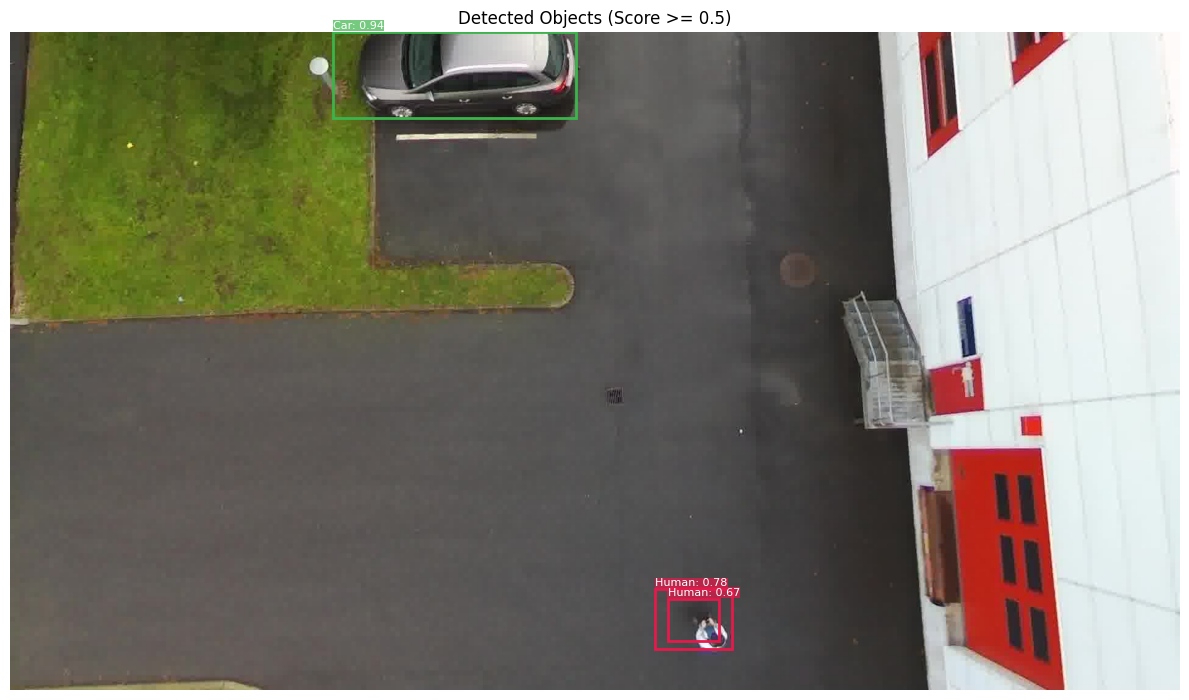

In [30]:
visualize_detections("dataset/auair/images/frame_20190829091111_x_0000165.jpg", scores, labels, boxes, id2label, 0.5)